# Image captioning
Χρησιμοποιώντας το tutorial του TensorFLow, https://www.tensorflow.org/tutorials/text/image_captioning , προσπαθούμε σε αυτή την εργασία να το βελτιώσουμε, ούτως ώστε με δοσμένη μία εικόνα, να δίνουμε μία accurate λεζάντα για αυτήν.

## Ομάδα 86


Σκουρτσή Δήμητρα - Άννα

Στεργιόπουλος Αναστάσιος

Φίλιππα Μυρσίνη

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
from keras.preprocessing.sequence import pad_sequences

## Εγκατάσταση του dataset

Σε αντίθεση με το tutorial, δε θα χρησιμοποιήσουμε το MS-COCO dataset, αλλά θα χρησιμοποιήσουμε το dataset flickr30k-images-ecemod, το οποίο περιέχει 31.783 εικόνες στο φάκελο image-dir από το Flickr, καθώς και 148.915 captions για τις εικόνες του "image_dir", το οποίο σημαίνει ότι για κάθε εικόνα, έχουμε περίπου 5 captions τα οποία θα χρησιμοποιήσουμε για να εκπαιδεύσουμε το νευρωνικό μας δίκτυο.

Παρακάτω παρατίθεται ο κώδικας που κατεβάζει το dataset που είναι hosted στο spartacus.

In [ ]:
# Download image files
image_zip = tf.keras.utils.get_file('flickr30k-images-ecemod.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='https://spartacus.1337.cx/flickr-mod/flickr30k-images-ecemod.zip',
                                      extract=True)
os.remove(image_zip)

# Download train captions file
train_captions_file = tf.keras.utils.get_file('train_captions.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/train_captions.csv',
                                           extract=False)

# Download test files list
test_images_file = tf.keras.utils.get_file('test_images.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/test_images.csv',
                                           extract=False)

40960/29242 [==========================================] - 0s 0us/step


Διαβάζουμε από τα csv και φορτώνουμε στο train_captions και test_images (τα οποία χρησιοποιούνται για το διαγωνισμό), τα δεδομένα που θα μας χρειαστούν παρακάτω.

In [ ]:
import pandas as pd
train_captions = pd.read_csv('train_captions.csv' ,header= None, sep = '|')
test_images = pd.read_csv('test_images.csv' ,header= None)

train_captions[0][0]

'_1000070808.jpg'

Δημιουργία διευθύνσεων των εικόνων για τις φωτογραφίες του διαγωνισμού.

In [ ]:
test_paths=[]
test_img_name_vector=[]
for i in range (0, len(test_images)):
    image_path = './image_dir/'+ test_images[0][i]
    test_paths.append(image_path)

for path in test_paths:
    test_img_name_vector.extend([path])

Πραγματοποιούμε tokenization των captions (από string λέξεων, σε λίστα λέξεων), για να φτιάξουμε ένα ιστόγραμμα που δείχνει ποιό είναι το πιο σύνηθες μήκος caption χωρίς προεπεξεργασία.

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


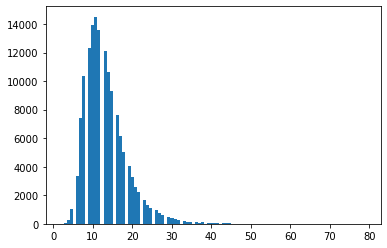

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

CAPTS_NUM = 148915

histogram = []
for i in range(CAPTS_NUM):
    count = len(word_tokenize(train_captions[2][i]))
    histogram.append(count)
    
np_histogram = np.array(histogram)
fig, ax = plt.subplots()
ax.hist(np_histogram, bins = 100)
plt.show()

Βλέπουμε στο παραπάνω ιστόγραμμα, πως το range δεν είναι 25 με 35 διαφορετικά μήκη, για αυτό, επιλέγουμε να "πετάξουμε" τα captions με μεγαλύτερο μήκος από 35 (τα θεωρούμε πολύ μεγάλα) καθώς και αυτά που έχουν μήκος μικρότερο από 5.

Επιπλέον, για τις επιλεγμένες περιγραφές, προσθέτουμε το start και end token και συνδέουμε κάθε εικόνα με τις περιγραφές της.

In [ ]:
MIN_LENGTH = 5
MAX_LENGTH = 35

image_path_to_caption = collections.defaultdict(list)
for i in range(CAPTS_NUM):
    length = len(word_tokenize(train_captions[2][i]))
    if (length >= MIN_LENGTH and length <=  MAX_LENGTH):
      caption = f"<start> {train_captions[2][i]} <end>"
      image_path = './image_dir/'+ train_captions[0][i]
      image_path_to_caption[image_path].append(caption)

Χρησιμοποιώντας random seed για να μπορούμε να συγκρίνουμε τις διαφορετικές μας προσπάθειες, διαλέγουμε από το dataset 7000 εικόνες από τις 31.000. 

Εδώ δε θέλουμε ούτε έναν πολύ μεγάλο αριθμό, αφού ο χρόνος εκτέλεσης της εκπαίδευσης θα ήταν πολύ μεγάλος, αλλά ούτε κάποιον μικρό, αφού θα είχαμε εύκολα φαινόμενο overfitting.

In [ ]:
image_paths = list(image_path_to_caption.keys())
random.seed(3)
random.shuffle(image_paths)

train_image_paths = image_paths[:7000]
print(len(train_image_paths))

7000


Για παράδειγμα, για μία εικόνα, έχουμε τα εξής captions.

In [ ]:
print(image_path_to_caption[train_image_paths[1]])

['<start>  Several people are gathered on the steps in front of a brick building . <end>', '<start>  A group of people are outside a brick building taking pictures . <end>', '<start>  people gather in front of building for speech <end>', '<start>  A group of people sits outside a building . <end>', '<start>  A group of people gathered for a meeting . <end>']


Δημιουργούμε τους πίνακες που περιέχουν την περιγρφή και το path της εικόνας στην αντίστοιχη θέση τους.

In [ ]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

Για παράδειγμα έχουμε:

<start>  An elderly gentleman attempting repairs on an inverted bicycle next too a silver vehicle . <end>


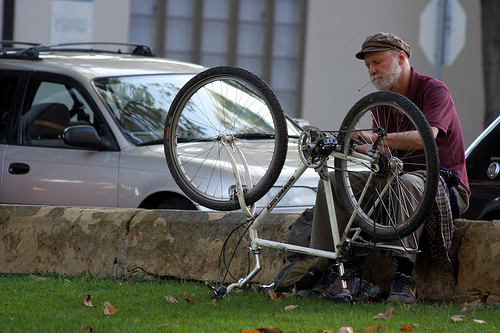

In [ ]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Προεπεξεργασία Κειμένου και tokenization των captions

Εδώ επαναλαμβάνουμε tokenization, αυτή τη φορά όμως, μετατρέπουμε σε lowercase και αφαιρούμε όλα τα είδη punctuation, εκτός των '<' και '>' που χρησιμοποιούνται για τα tokens start και end.

Επιπλέον, κατ'επίδειξη των βοηθών του εργαστηρίου, αφαιρούμε και τους αριθμούς.

Υπολογίζεται ένα vocabulary που ενώ στο tutorial ήταν μεγέθους 5000 (δηλαδή οι 5000 πιο χρησιμοποιημένες λέξεις στα captions), αποφασίσαμε να το αυξήσουμε στις 7500 4000, αφού βλέπουμε καλύτερες επιδόσεις.

Τέλος, πραγματοποιούμε mapping word-to-index, καθώς και index-to word για να είναι εύκολη η μετάβαση από πραγματική λέξη στον κωδικό της στο συγκεκριμένο λεξιλόγιο και το αντίστροφο.

In [ ]:
!pip install pycocotools --user #None of the MLIR Optimization Passes are enabled

def remove_punc(string):
    punc = '''!()-[]{};:'"\,./?@#$%^&*_~0123456789'''
    for char in string:  
        if char in punc:  
            string = string.replace(char, "") 
    return string

train_captions = [remove_punc(i) for i in train_captions]

        
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

def standardize(inputs):
    return tf.strings.lower(inputs)

# Max word count for a caption.
max_length = 35

# Use the top 7500 words for a vocabulary.
vocabulary_size = 7500
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)

# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)
vocabulary=tokenizer.get_vocabulary()

# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

     |████████████████████████████████| 106 kB 901 kB/s            
  Installing build dependencies ... - \ | / - \ | / done
  Getting requirements to build wheel ... - \ | done
  Preparing metadata (pyproject.toml) ... - \ | / done
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp37-cp37m-linux_x86_64.whl size=370022 sha256=782413eb35d0eb23905e9c8c8e3ea68327abc1e42ac3d4626b3daf8dce54024c
  Stored in directory: /root/.cache/pip/wheels/a3/5f/fa/f011e578cc76e1fc5be8dce30b3eb9fd00f337e744b3bba59b
Successfully built pycocotools


Για παράδειγμα βλέπουμε τις 5 πρώτες λέξεις του vocabulary μας, δηλαδή τις 5 πιο συνήθεις.

In [ ]:
print(vocabulary[:5])

['', '[UNK]', 'a', '<start>', '<end>']


In [ ]:
print(vocabulary[3])

<start>


In [ ]:
print(int(word_to_index(tf.convert_to_tensor('<start>'))))

3


## Προεπεξεργασία των εικόνων (Xception)
Λόγω του αριθμού της ομάδας μας (86%4 = 2), χρησιμοποιούμε έτοιμο μοντέλο CNN του Keras Xception, που έχει καλύτερες επιδόσεις από το έτοιμο μοντέλο InceptionV3 που χρησιμοποιείται από το tutorial.

Για το μοντέλο Xception, διαβάζουμε στο documentation https://keras.io/api/applications/xception/ , πως το default input image size είναι 299x299, επιπλέον βλπέπουμε πως πρέπει να καλέσουμε το tf.keras.applications.xception.preprocess_input στα inputs μας πριν τα "ταίσουμε" στο μοντέλο, το οποίο κάνει scale τα pixels μεταξύ -1 και 1.

Συνεπώς, ανοίγουμε την εικόνα, αποκωδικοποιούμε (αφού πρόκειται για jpeg) και στη συνέχεια την κανουμε resize στο 299x299 και κάνουμε και scale τα pixels οπως αναφέρθηκε παραπάνω.

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.xception.preprocess_input(img)
    return img, image_path

## Χρήση μοντέλου Xception
Initialization του μοντέλου CNN Xception

Στο hidden layer αποθηκεύουμε το τελευταίο output layer, το οποίο θα μας φανέι χρήσιμο στο τέλος, όπου δείχνουμε πάνω στην εικόνα, ποια περιοχή pixels μας οδήγησε στην επιλογή μίας λέξης (attention layer)

In [ ]:
image_model = tf.keras.applications.Xception(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

83697664/83683744 [==============================] - 0s 0us/step


## Αποθήκευση στο cache των features που έγιναν extracted από το Xception

In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(100)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

2022-03-08 17:22:02.772572: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


## Split των δεδομένων σε train και validation 
Πραγματοποιούμε όπως στο tutorial split (80-20) του dataset.

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(27798, 27798, 6946, 6946)

## Δημιουργία tf.data dataset για εκπαίδευση του μοντέλου.

In [ ]:
BATCH_SIZE = 100
BUFFER_SIZE = 1000
embedding_dim = 200 #επειδή θα χρησιμοποιήσουμε το wiki-200
units = 512
num_steps = len(img_name_train) // BATCH_SIZE

# Shape of the vector extracted from Xception is (100, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 100

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Χρήση gensim για pre-trained word2vec 
Όπως στην προηγούμενη εργασία, χρησιμοποιούμε το pre-trained word vector μοντέλο wiki-gigaword-200

In [ ]:
!pip install -U gensim
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

     |████████████████████████████████| 24.1 MB 889 kB/s            
  Attempting uninstall: gensim
    Found existing installation: gensim 4.0.1
    Uninstalling gensim-4.0.1:
      Successfully uninstalled gensim-4.0.1
['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
model_wiki_200 = gensim.downloader.load("glove-wiki-gigaword-200")

[==================================================] 100.0% 252.1/252.1MB downloaded


## Μοντέλο

Αντίστοιχα με το μοντέλο του tutorial:

* Παίρνουμε τα features του τελευταίου συνελικτικού επιπέδου του Xception, το οποίο είναι ένα διάνυσμα με shape (10, 10, 2048).

* Το μετατρέπουμε σε shape (100, 2048).

* Αυτό δίνεται ως είσοδος σε ένα CNN Encoder (ένα μοναδικό fully connected επίπεδο).

* Τέλος το RNN (χρησιμοποιούμε όπως στο tutorial GRU ενώ κάναμε δοκιμές και με LSTM χωρίς όμως να δουμε καλύτερη επίδοση στο BLEU score) κοιτάει την εικόνα και προβλέπει την επόμενη λέξη.

Στο RNN εχουμε προσθέσει dropout για την "καταπολέμιση" του overfitting, με τη χρήση του οποίου βλέπουμε πως αυξάνεται η επίδοση κατά ένα ποσοστό 3%

Για την αποφυγή της εκπαίδευσης του embedding, θέτουμε trainable = false

In [ ]:
from keras.layers import Embedding

vocab_size=len(vocabulary)
embedding_matrix = np.zeros((vocab_size, embedding_dim)) # to import as weights for Keras Embedding layer

for i in range(0,vocab_size):
    word = vocabulary[i]
    
    if word in model_wiki_200.index_to_key:
        embedding_vector = model_wiki_200[word]
        if embedding_vector is not None:
            # Words not found in the embedding index will be all zeros
            embedding_matrix[i] = embedding_vector
    
embedding_layer = Embedding(vocab_size, embedding_dim, mask_zero=True, trainable=False)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) 

    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer 
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    score = self.V(attention_hidden_layer)

    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = embedding_layer
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)
    self.drop = tf.keras.layers.Dropout(0.25)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)
    
    x = self.drop(x) 

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)
    
    x = self.drop(x) 

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Εκπαίδευση

* Από τα .npy files δίνουμε τα features στον encoder.

* Η έξοδος του encoder, hidden state(initialized to 0) και το start token, δίνεται στον decoder.

* Ο decoder επιστρέφει τις προβλέψεις και το hidden state που χρησιμοποιείται ως είσοδος πάλι στο μοντέλο για να υπολογιστεί το Loss.

* Στη συνέχεια η λέξη που προβλέπεται δίνεται ως είσοδος στον decoder και ξαναξεκινάμε.

* Τέλος, υπολογίζονται τα gradients, εφαρμόζονται στον optimizer και γίνεται backpropagation.


In [ ]:
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index(tf.convert_to_tensor('<start>'))] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

Τρέχουμε για 80 Epochs, μιας και εμπειρικά μας φαίνεται ενα καλό σημείο χωρίς ιδιαίτερο overfitting ή underfitting.

In [ ]:
EPOCHS = 80

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 3.2574
Epoch 1 Batch 100 Loss 1.6199
Epoch 1 Batch 200 Loss 1.5111
Epoch 1 Loss 1.750901
Time taken for 1 epoch 122.81 sec

Epoch 2 Batch 0 Loss 1.5798
Epoch 2 Batch 100 Loss 1.4006
Epoch 2 Batch 200 Loss 1.4395
Epoch 2 Loss 1.417601
Time taken for 1 epoch 51.17 sec

Epoch 3 Batch 0 Loss 1.4028
Epoch 3 Batch 100 Loss 1.2959
Epoch 3 Batch 200 Loss 1.2115
Epoch 3 Loss 1.295207
Time taken for 1 epoch 50.43 sec

Epoch 4 Batch 0 Loss 1.3343
Epoch 4 Batch 100 Loss 1.3130
Epoch 4 Batch 200 Loss 1.1648
Epoch 4 Loss 1.208300
Time taken for 1 epoch 56.95 sec

Epoch 5 Batch 0 Loss 1.2171
Epoch 5 Batch 100 Loss 1.1684
Epoch 5 Batch 200 Loss 1.0641
Epoch 5 Loss 1.138456
Time taken for 1 epoch 50.50 sec

Epoch 6 Batch 0 Loss 1.2360
Epoch 6 Batch 100 Loss 1.1159
Epoch 6 Batch 200 Loss 1.1078
Epoch 6 Loss 1.076579
Time taken for 1 epoch 51.12 sec

Epoch 7 Batch 0 Loss 1.0909
Epoch 7 Batch 100 Loss 1.0598
Epoch 7 Batch 200 Loss 1.0011
Epoch 7 Loss 1.020833
Time taken for 1 epoch 50

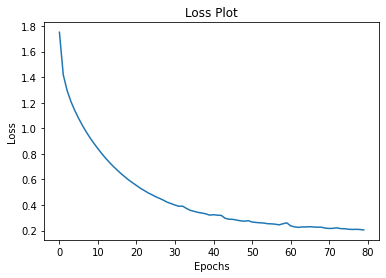

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

Στο παραπάνω διάγραμμα φαίνεται η πορεία του loss κατά τις ενδιάμεσες εποχές. Με το πέρας 80 εποχών παρατηρούμε ότι έχει φτάσει κάτω από 0.2, τιμή η οποία είναι ικανοποιητική για να προχωρήσουμε στο evaluation.

## Evaluation

* για το evaluation, συνεχίζουμε όπως πριν αλλά σε αντίθεση με προηγουμένως, δίνουμε στον decoder τις προβλέψεις, το hidden state και την εξοδο του encoder.

* Όταν το μοντέλο προβλέψει ολόκληρη την περιγραφή, τελείωνει το evaluation και αποθηκεύονται τα attention weights για κάθε βήμα.


Το παράδειγμα του tutorial χρησιμοποιεί την tf.random.categorical για να επιλέξει την επόμενη λέξη, εμείς όμως, για τη βελτιστοποίηση, χρησιμοποιούμε beam search με b = 3, μιας και για το συγκεκριμένο b, έχουμε τα καλύτερα αποτελέσματα.

In [ ]:
def beam_search_pred(model, pic_fe, wordtoix, K_beams = 5, log = False):
    attention_plot = np.zeros((max_length, attention_features_shape))
    start = [int(word_to_index(tf.convert_to_tensor('<start>')))]
    
    end_token = '<end>'
    start_word = [[start, 0.0]]
    
    dec_input = tf.expand_dims([word_to_index(tf.convert_to_tensor('<start>'))], 0)
    
    hidden = decoder.reset_state(batch_size=1)
    
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            if (s[0] != start): 
                dec_input = tf.expand_dims([s[0][-1]], 0)
            sequence  = pad_sequences([s[0]], maxlen=max_length).reshape((1,max_length)) #sequence of most probable words based on the previous steps
                        
            preds, hidden, attention_weights = decoder(dec_input, pic_fe, hidden)
                       
            attention_plot[len(start_word[0][0])-1] = tf.reshape(attention_weights, (-1, )).numpy()
            
            probabilities = tf.nn.softmax(preds, name = 'Predictions')
            
            word_preds = np.argsort(probabilities[0])[-K_beams:] # sort predictions based on the probability, then take the last
                                                                 # K_beams items. words with the most probs
            #print(word_preds)
            # Getting the top <K_beams>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(probabilities[0][w]) # assign a probability to each K words4
                else:
                    prob += probabilities[0][w]
                temp.append([next_cap, prob])
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])

        # Getting the top words
        start_word = start_word[-K_beams:]
    #print(start_word)
    start_word = start_word[-1][0]

    captions_ = [vocabulary[i] for i in start_word]


    final_caption = []
    
    for i in captions_:
        if i != end_token:
            final_caption.append(i)
        else:
            break
    
    final_caption = final_caption[1:] #removing start token
    attention_plot = attention_plot[:len(final_caption), :]
    return final_caption, attention_plot

In [ ]:
def evaluate(image):
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)  
    result, attention_plot = beam_search_pred(decoder, features, word_to_index, K_beams = 3, log=True)
    return result, attention_plot

Υλοποίηση του plot attention όπως στο Tutorial

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Μικρή συνάρτηση που απεικονίζει με όμορφο τρόπο το progress ενός task που βρήκαμε στο διαδίκτυο.

In [ ]:
import sys
def progress(value, endvalue, bar_length=20,job='Loading'):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

Για κάθε εικόνα που ανήκει στο validation set, βρίσκουμε και αποθηκεύουμε στον πίνακα actuals τις δοσμένες περιγραφές της, καθώς και με χρήση του μοντέλου προβλέπουμε μία περιγραφή την οποία αποθηκεύουμε στον πίνακα prediction.

In [ ]:
# captions on the validation set
prev_image = []
actuals = []
prediction = []
id_og = 0
while (id_og < len(img_name_val)):
    progress(id_og, len(img_name_val), bar_length=20,job='Loading Evaluation')
    actual = []
    image_og = img_name_val[id_og]
    while(image_og in prev_image):
        id_og += 1
        if(id_og >= len(img_name_val)):
            break
        else:
            image_og = img_name_val[id_og]
    id = max(0,id_og-4)
    id_max=min(len(img_name_val)-1,id_og+4)
    while id <= id_max:
        if(id < id_og and img_name_val[id] != image_og):
            id += 1
        else:
            if(id > id_og and img_name_val[id] != image_og):
                id_og = id
                break
            else:
                real_caption = [tf.compat.as_text(index_to_word(i).numpy())
                             for i in cap_val[id] if i not in [0]]
                id += 1
                real_caption.pop(0)
                real_caption.pop(-1)
                actual.append(real_caption)
    actuals.append(actual)
    result, attention_plot = evaluate(image_og)
    prediction.append(result)
    prev_image.append(image_og)
    id_og += 1

print("\n")
print("Actuals", actuals[:1])
print("Predictions", prediction[:1])

Loading Evaluation [------------------->] 100%

Actuals [[['a', 'smiling', 'man', 'is', 'sitting', 'in', 'the', 'chair', 'and', 'drinking', 'alcoholic', 'beverage'], ['a', 'man', 'is', 'sitting', 'down', 'and', 'getting', 'ready', 'to', 'enjoy', 'a', 'glass', 'of', 'liquor'], ['a', 'man', 'enjoys', 'a', 'drink', 'while', 'sitting', 'in', 'a', 'brown', 'chair'], ['a', 'man', 'is', 'drinking', 'wine', 'while', 'sitting', 'in', 'a', 'chair'], ['a', 'man', 'smiling', 'while', 'drinking']]]
Predictions [['a', 'man', 'with', 'sunglasses', 'is', 'sitting', 'on', 'the', 'chair', 'drinking']]


Για τον υπολογισμό του BLEU score χρησιμοποιείται η συνάρτηση corpus_bleu, με ορίσματα τους πίνακες actuals και prediction.

Χρησιμοποιήθηκαν τα βάρη και η smoothing συνάρτηση που υποδείχθηκε από την εκφώνηση.

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
score = corpus_bleu(actuals, prediction, smoothing_function=SmoothingFunction().method1, weights=(0.4, 0.3, 0.2, 0.1))
print("BLEU score", score)

BLEU score 0.18145367795176698


## Δοκιμή με την εικόνα του tutorial - επιτυχημένο captionning



73728/64400 [==================================] - 0s 2us/step
Prediction Caption: a surfer is currently on a wave in the ocean


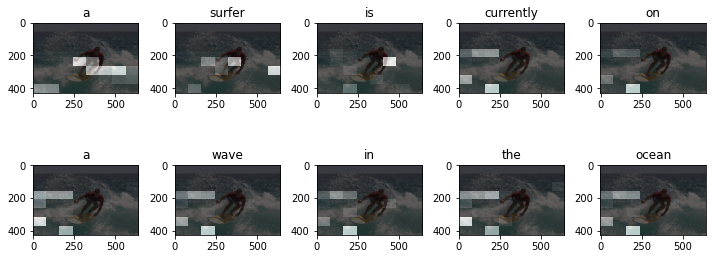

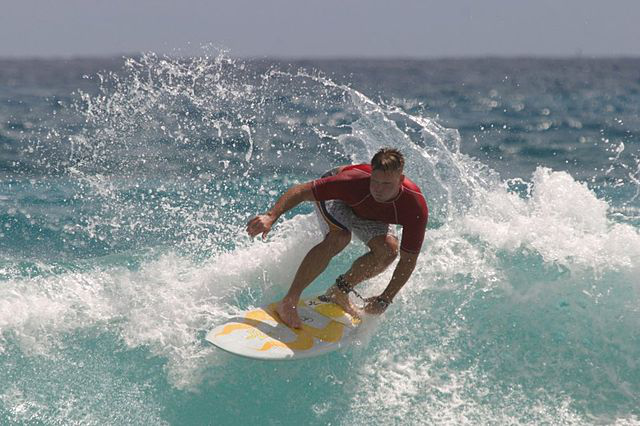

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

## Αποτυχημένο - Αστείο captioning

Με μία εικόνα που πήραμε απο το Google Images με ενα σκύλο και ενα παιδάκι που παίζουν με μία μπάλα, το prediction είναι αρκετά κοντινό στην πραγματικότητα αλλά όχι αρκετά.

90112/73793 [====================================] - 0s 1us/step
Prediction Caption: two boys playing with a ball


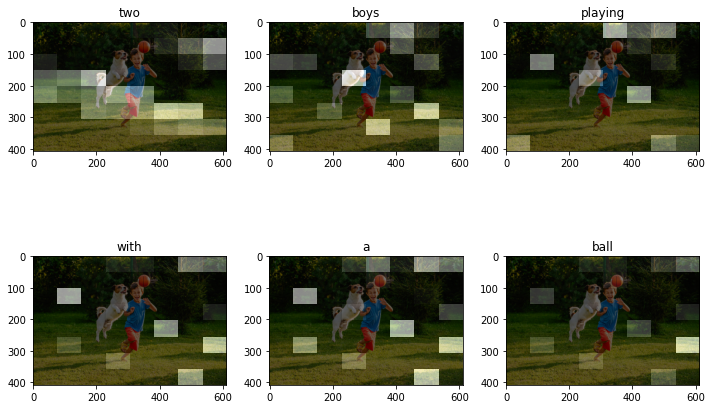

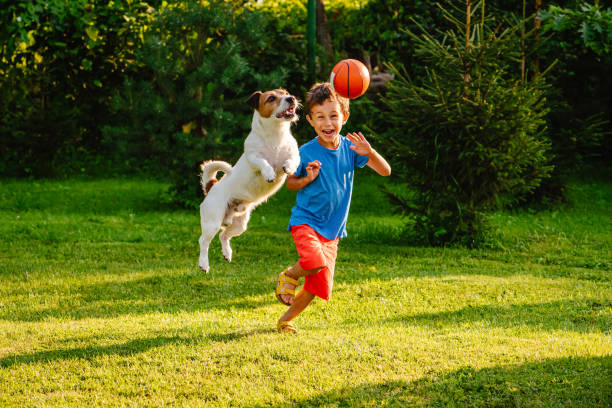

In [ ]:
image_url = 'https://media.istockphoto.com/photos/family-having-fun-outdoor-with-dog-and-basketball-ball-picture-id1154596591?k=20&m=1154596591&s=612x612&w=0&h=HofC7fDHtEkQswJO_CK6Ae5QoR7SZijhpjO1rVOVsRc='
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

## Διαγωνισμός

Για τη συμμετοχή στο διαγωνισμό, κάνουμε evaluate τις test images και τις αποθηκεύουμε σε ένα json file.

In [ ]:
import json 
test_hypothesis = []

for i in range(0, len(test_img_name_vector)):
    result, attention_plot = evaluate(test_img_name_vector[i])
    test_hypothesis.append(result)

jsonString = json.dumps(test_hypothesis)
jsonFile = open("test_hypotheses.json", "w")
jsonFile.write(jsonString)
jsonFile.close()

Λάβαμε μέρος στο διαγωνισμό του Codalab με διάφορες υποβολές από BLEU score 0.22 μέχρι 0.26 που μας κατατάσσει 3ους στο διαγωνισμό αυτή τη στιγμή (ομάδα Team_86, user achilles) σε όλες μας τις υποβολές παρατηρήσαμε ότι το BLEU score που υπολογίσαμε ήταν κατά 0.08 λιγότερο απ' ότι στο Codalab παρ'ότι έχουμε χρησιμοποιήσει τις σωστές παραμέτρους στο BLEU smoothing_function=SmoothingFunction().method1, weights=(0.4, 0.3, 0.2, 0.1). Η εκπαίδευση έγινε στο kaggle και πήρε περίπου 4 ώρες και 50 λεπτά

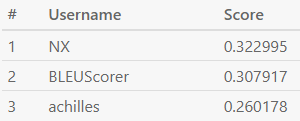